In [2]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD


In [3]:
# config
batch_size = 128
epochs = 20
reg = 0.0001
# reg = 0

titledf=pd.read_csv("C://Users//Admin//Downloads//archive//movie.csv")#for predicting movie titles
A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)



# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)



def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n


def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      a = a - mu * m # must keep zeros at zero!
      # m2 = (np.random.random(a.shape) > 0.5)
      # noisy = a * m2
      noisy = a # no noise
      yield noisy, a


def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at



model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)


r = model.fit(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())


N: 10000 M: 2000
N // batch_size: 78
mu: 3.4481185176255673


C:\Users\Admin\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
79/79 [==============================] - 7s 80ms/step - loss: 1.1942 - custom_loss: 0.9872 - val_loss: 0.9264 - val_custom_loss: 0.7267
Epoch 2/20
79/79 [==============================] - 6s 74ms/step - loss: 0.9492 - custom_loss: 0.7550 - val_loss: 0.8710 - val_custom_loss: 0.6802
Epoch 3/20
79/79 [==============================] - 6s 76ms/step - loss: 0.8869 - custom_loss: 0.7018 - val_loss: 0.8393 - val_custom_loss: 0.6563
Epoch 4/20
79/79 [==============================] - 6s 71ms/step - loss: 0.8440 - custom_loss: 0.6643 - val_loss: 0.8153 - val_custom_loss: 0.6392
Epoch 5/20
79/79 [==============================] - 5s 70ms/step - loss: 0.8112 - custom_loss: 0.6389 - val_loss: 0.7974 - val_custom_loss: 0.6275
Epoch 6/20
79/79 [==============================] - 5s 68ms/step - loss: 0.7856 - custom_loss: 0.6191 - val_loss: 0.7817 - val_custom_loss: 0.6175
Epoch 7/20
79/79 [==============================] - 6s 77ms/step - loss: 0.7632 - custom_loss: 0.6019 - val_loss: 0.76

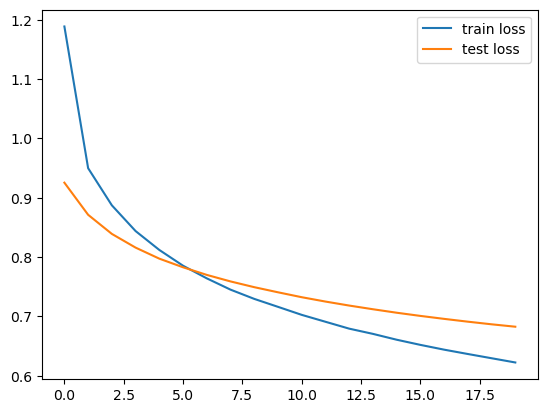

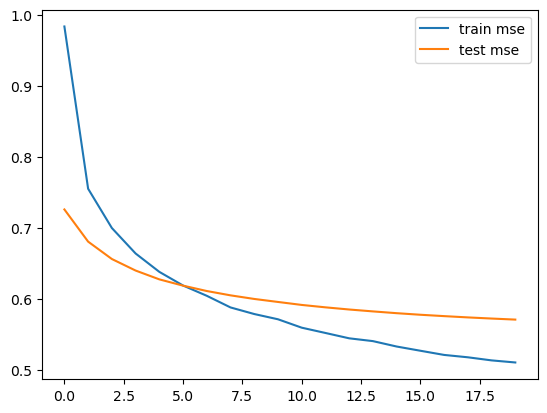

In [4]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

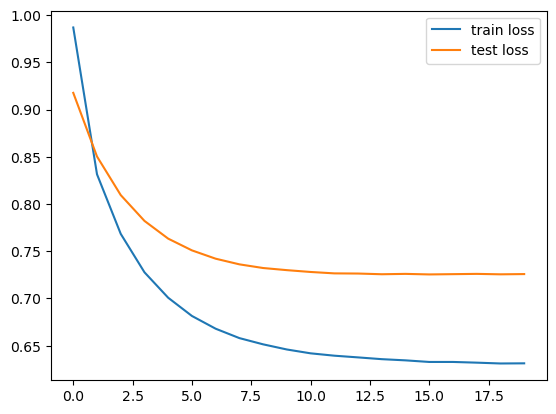

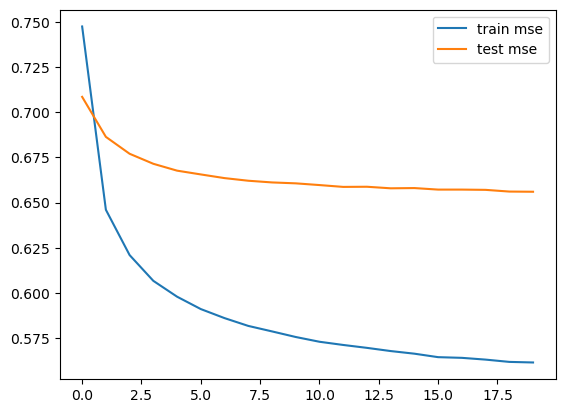

In [8]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import keras.backend as K

# Load the data
titledf = pd.read_csv("C://Users//Admin//Downloads//archive//movie.csv")
A = load_npz("Atrain.npz")
mask = (A > 0) * 1.0

# center the data
mu = A.sum() / mask.sum()

# Build the model
M = A.shape[1]
i = Input(shape=(M,))
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(0.0001))(x)
x = Dense(M, kernel_regularizer=l2(0.0001))(x)

model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=[custom_loss],
)

# Generate predictions for user 100
user_100_data = A[100, :].toarray()
user_100_data = user_100_data - mu * mask[100, :].toarray()
predicted_ratings = model.predict(user_100_data)

# Get the indices of top 10 movies with highest predicted ratings
top_10_movie_indices = np.argsort(predicted_ratings[0])[::-1][:10]

# Print the recommended movies
print("Recommended movies for user 100:")
for movie_idx in top_10_movie_indices:
    movie_title = titledf.loc[titledf['movieId'] == movie_idx, 'title'].values[0]
    print("- ", movie_title)


1/1 [==============================] - 0s 96ms/step
Recommended movies for user 100:
-  Armageddon (1998)
-  Wedding Gift, The (1994)
-  Madness of King George, The (1994)
-  Nenette and Boni (Nénette et Boni) (1996)
-  Picture Bride (Bijo photo) (1994)
-  Preacher's Wife, The (1996)
-  Breaking the Waves (1996)
-  Nell (1994)
-  Pompatus of Love, The (1996)
-  301, 302 (301/302) (1995)


C:\Users\Admin\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
df = pd.read_csv("C://Users//Admin//Documents//GitHub//small_rating.csv")
# Calculate predictions for user 100
user_predictions = model.predict(A)
user_predictions = user_predictions.flatten() + mu

# Retrieve the user ratings for user 100
user_ratings = df[df['userId'] == 100]

# Calculate the root mean squared error (RMSE) for user 100
rmse = np.sqrt(np.mean((user_ratings['rating'].values - user_predictions[user_ratings['movie_idx'].values])**2))

print("RMSE for User 100:", rmse)


313/313 [==============================] - 11s 35ms/step
RMSE for User 100: 1.2896794835507943


In [19]:
user_predictions = model.predict(A)
user_predictions = user_predictions.flatten() + mu

user_ratings = df[df['userId'] == 100]

# Set a threshold to classify positive ratings
threshold = 3.5

# Calculate precision and recall
predicted_positive = np.where(user_predictions[user_ratings['movie_idx'].values] >= threshold, 1, 0)
actual_positive = np.where(user_ratings['rating'].values >= threshold, 1, 0)

true_positive = np.sum(predicted_positive * actual_positive)
predicted_positive_count = np.sum(predicted_positive)
actual_positive_count = np.sum(actual_positive)

precision = true_positive / predicted_positive_count
recall = true_positive / actual_positive_count

# Print the precision and recall
print("Precision for User 100:", precision)
print("Recall for User 100:", recall)


313/313 [==============================] - 13s 40ms/step
Precision for User 100: 0.7101787101787101
Recall for User 100: 0.9956427015250545
